In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO, DDPG, A2C, TD3
from stable_baselines import PPO2
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
# delete the first column and the last column
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

ModuleNotFoundError: No module named 'stable_baselines'

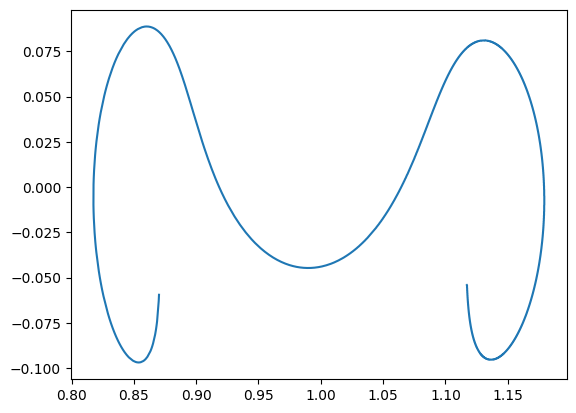

In [2]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [134]:
# three body problem env

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-20, high=20, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        self.position_arg = 0
        self.last_position_arg = 0
        self.index_counter = 0
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        a_x = action[0]
        a_y = action[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x/10
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y/10

        x = x + xdot*self.dt
        y = y + ydot*self.dt

        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        # plot positon and trajectory and action
        # plt.figure(figsize=(10,10))
        # plt.plot(self.trajectory[:,0], self.trajectory[:,1])
        # plt.scatter(self.position[0], self.position[1], c='r')
        # plt.scatter(self.trajectory[self.position_arg][0], self.trajectory[self.position_arg][1], c='g')
        # plt.scatter(self.trajectory[self.last_position_arg][0], self.trajectory[self.last_position_arg][1], c='b')
        # # plot ax ay vector
        # plt.arrow(self.position[0], self.position[1], a_x/1000, a_y/1000, width=0.001, color='r')
        # plt.show()

        self.steps += 1

        # find the closest point in the trajectory
        self.position_arg = np.argmin(np.linalg.norm(self.trajectory[:, 0:2] - self.position[0:2], axis=1))
        # if the agent is not moving, give a negative reward
        distace = np.linalg.norm(self.trajectory[self.position_arg, 0:2] - self.position[0:2])
        reward = -1000000*distace**2 - abs(a_x)/10 - abs(a_y)/10
        if self.position_arg == self.last_position_arg:
            reward += -1
            print(1)
            plt.figure(figsize=(10,10))
            plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            plt.scatter(self.position[0], self.position[1], c='r')
            plt.scatter(self.trajectory[self.position_arg][0], self.trajectory[self.position_arg][1], c='g')
            plt.scatter(self.trajectory[self.last_position_arg][0], self.trajectory[self.last_position_arg][1], c='b')
            # plot ax ay vector
            plt.arrow(self.position[0], self.position[1], a_x/1000, a_y/1000, width=0.001, color='r')
            plt.show()
        elif self.position_arg > self.last_position_arg:
            # print(2)
            reward += 100*np.exp(self.last_position_arg - self.position_arg)
            self.last_position_arg = self.position_arg
        else:
            reward += -10

        # add reward if the agent is closer to the trajectory
        print(reward, a_x, a_y)
        print(distace)
        if distace > 0.01:
            reward = -100
            done = True
        else:
            done = False

        if self.steps > self.max_steps:
            done = True

        observation = -100*(self.position - self.trajectory[self.position_arg])
        return observation, reward, done, {}

    def reset(self):
        self.steps = 0
        self.position = self.trajectory[0]
        self.position_arg = 0
        self.last_position_arg = 0
        return -100*(self.position - self.trajectory[1])

    def render(self, mode='human'):
        pass

    def close(self):
        pass

    def seed(self, seed=None):
        pass

In [135]:
env = three_body_env(trajectory)
# Create a TD3 agent
model = PPO('MlpPolicy', env)

In [136]:
# learn model with show log
model.learn(total_timesteps=100000, reset_num_timesteps=False, tb_log_name="TD3", log_interval=10)
# save model
model.save("ppo_three_body")

-0.1333966712181897 0.85162455 0.4673965
3.8679317470698e-05
-0.2090098805219507 -1.1580259 -0.92062783
3.3838904853418176e-05
-0.13160513035962268 -0.087830946 1.2092934
4.352266334685577e-05
-0.17703854854243176 -1.0634578 -0.67758596
5.417313185030495e-05
-0.09792021295511492 0.52534837 -0.4395804
3.7800242730863144e-05
-0.09763552825672751 0.7436158 0.19158272
6.41578949225589e-05
-0.15087845504082742 -0.19159529 -1.2859735
5.5884653857703796e-05
-0.4793357104894303 2.2604208 -2.4626932
8.381449398455242e-05
-0.10489866844901798 -0.85554355 -0.030361475
0.0001277056216595205
-0.07074503107723105 0.24247001 0.21209462
0.00015902555850664008
-0.3589191781350917 1.1501276 -2.0317779
0.00020181712100049396
-0.18177411916100414 0.47844076 0.6787865
0.00025700505345380403
-0.14535953088261439 0.32650223 0.05913133
0.0003267976967692863
-0.2548112263830151 0.86982673 0.113564596
0.0003955657967187839
-0.3571799119649219 0.1940591 -1.165726
0.0004703221554929377
-0.5052718668368109 0.92835

In [137]:
# test trained model
# save states
position = np.zeros((1000, 4))
env = three_body_env(trajectory)
obs = env.reset()
action_ = []
for i in range(1000):
  action, _states = model.predict(obs, deterministic=True)
  obs, rewards, dones, info = env.step(action)
  position[i] = env.position
  action_.append(action)
  env.render()
  if dones:
    obs = env.reset()

env.close()

-0.01853181111565544 -0.14889032 -0.021482129
3.8679317470698e-05
-0.015582593871415749 -0.1341359 -0.016397528
2.3017626359583195e-05
-0.016818866749515556 -0.13814238 -0.017075505
3.6036114148339034e-05
-0.01648296065954173 -0.13292655 -0.015121482
4.097215345987789e-05
-0.01669746377596027 -0.13621897 -0.015289336
3.934662151041898e-05
-0.018061481000938576 -0.12992527 -0.012906507
6.147246557604602e-05
-0.017442531288202306 -0.13413861 -0.013762359
5.1516570486032125e-05
-0.0193388670560431 -0.1267158 -0.0107267685
7.480087608293654e-05
-0.020204341904425365 -0.13072199 -0.01153101
7.733411437398563e-05
-0.021046379019158592 -0.12379171 -0.009052515
8.81051465102021e-05
-0.022480849719350736 -0.12689546 -0.009113722
9.424147076396956e-05
-0.022984699604824355 -0.11963314 -0.006770119
0.00010171004945131786
-0.025287142995477234 -0.12239659 -0.006689746
0.00011126559471651563
-0.027561058815615613 -0.11493793 -0.004126705
0.00012512056362728777
-0.02872191985471809 -0.11830354 -0.00

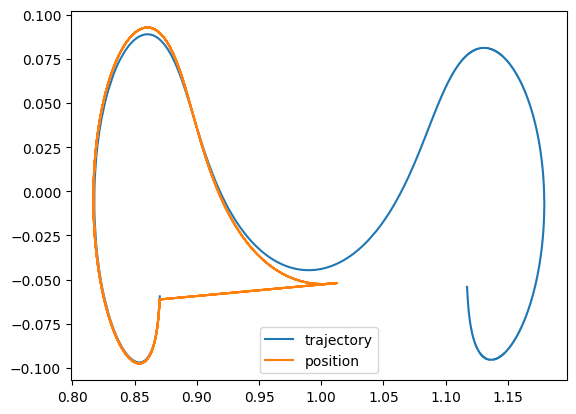

In [138]:
# plot position
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(position[:,0], position[:,1])
plt.legend(['trajectory', 'position'])
plt.show()